## Time Series

<ul>
    <li>A time series is a sequence set of data points, measured typically over successive times</li>
    <li>It is mathematically defined as a set of vecotrs x(t), t=0,1,2,... where t represents the time elapsed</li>
    <li>The variable x(t) is treated as a random variable</li>
    <li>The measurement taken during an event in a time series are arranged in a proper chronological order</li>
    <li>A time series containing records of a single variable is termed as univariante and more than one variable a multivariant</li>
</ul>

## Business use cases of time series forcasting

<ul>
    <li>Sales forcast - retail products sales forcast</li>
    <li>Demand forcasting - uses in pricing, inventory and workforce management</li>
    <li>Traffic forecast - transport and route optimization, road facility design</li>
    <li>Revenue forcast - budgeting, target setting</li>
</ul>

## Importing Libraries for time series forcasting

In [1]:
import warnings 
import itertools
import numpy as numpy
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error


## Importing Data

<ul>
    <li>Dataset: International airline passenger</li>
    <li>Unit: Thousands</li>
</ul>

In [2]:
df = pd.read_csv('data/international-airline-passengers.csv')

In [3]:
df.shape

(144, 2)

In [4]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.rename(columns = {'Month': 'year', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'passengers'}, inplace = True)

In [6]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [7]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
df.describe(include='O')

,year
count,144
unique,144
top,1959-07
freq,1


## Data Preprocessing and Visualization

#### Converting to datetime format

In [9]:
df['year'] = pd.to_datetime(df['year'], format = '%Y-%m')

#### Setting index as the datetime column for easier manipulations:

In [10]:
y = df.set_index('year')

In [11]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [12]:
y.isnull().sum()

passengers    0
dtype: int64

<AxesSubplot:xlabel='year'>

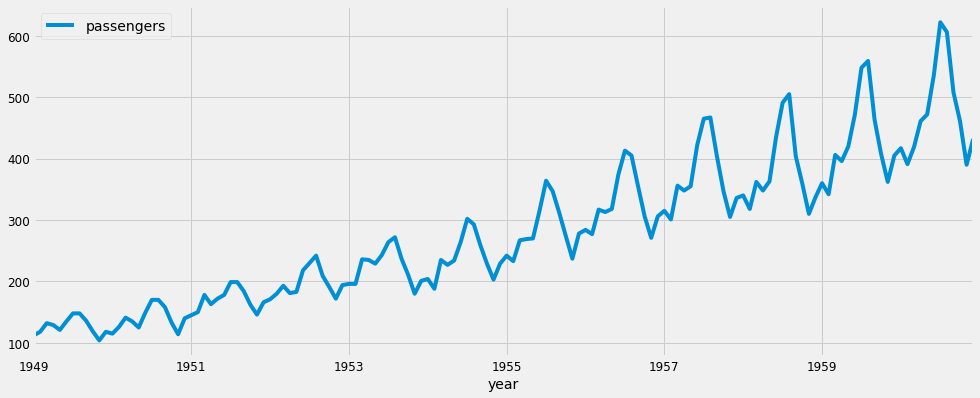

In [13]:
y.plot(figsize=(15, 6))

#### Reviewing plots of the density of observations can provide future insight intothe structure of the data:

<ul>
    <li>The distribution is not perfectly Gaussian (normal distribution)</li>
    <li>The distribution is left shifted</li>
    <li>Transformation might be usefull prior to modeling</li>
</ul>

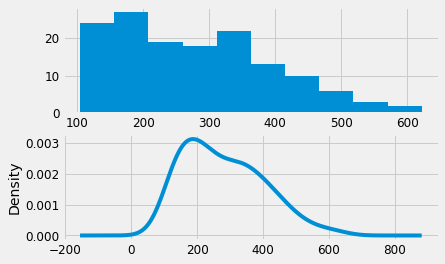

In [14]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

#### Box and Whisker Plots:

<ul>
<li>Median value across year confirms an upwards trend</li>
<li>Stedy increases in the spread or middle 50% of the data (boxes) over time</li>
<li>A model considering seasonality might work well</li>
</ul>

<AxesSubplot:xlabel='year', ylabel='passengers'>

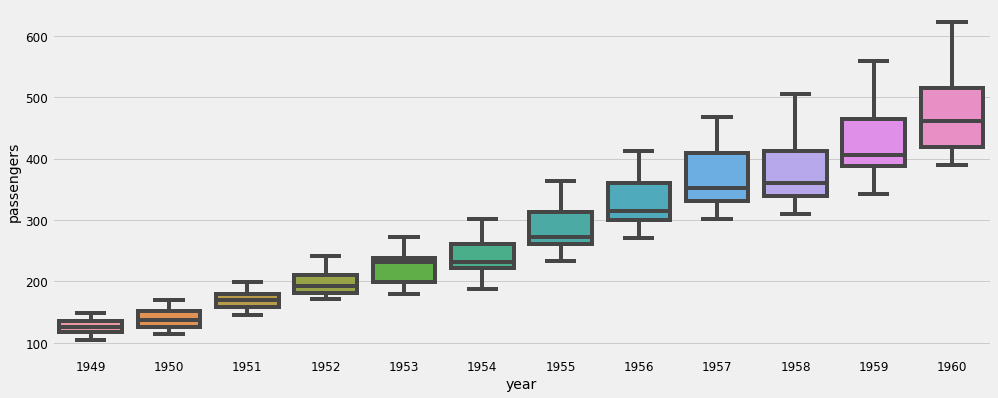

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

### Decomposing using stats model:

<ul>
<li>We can use stats model to perform a decomposition of this time series</li>
<li>The decomposing of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns</li>
<li>With stats models we will be able to see the trends seasonal, and residual components of out data. </li>
</ul>

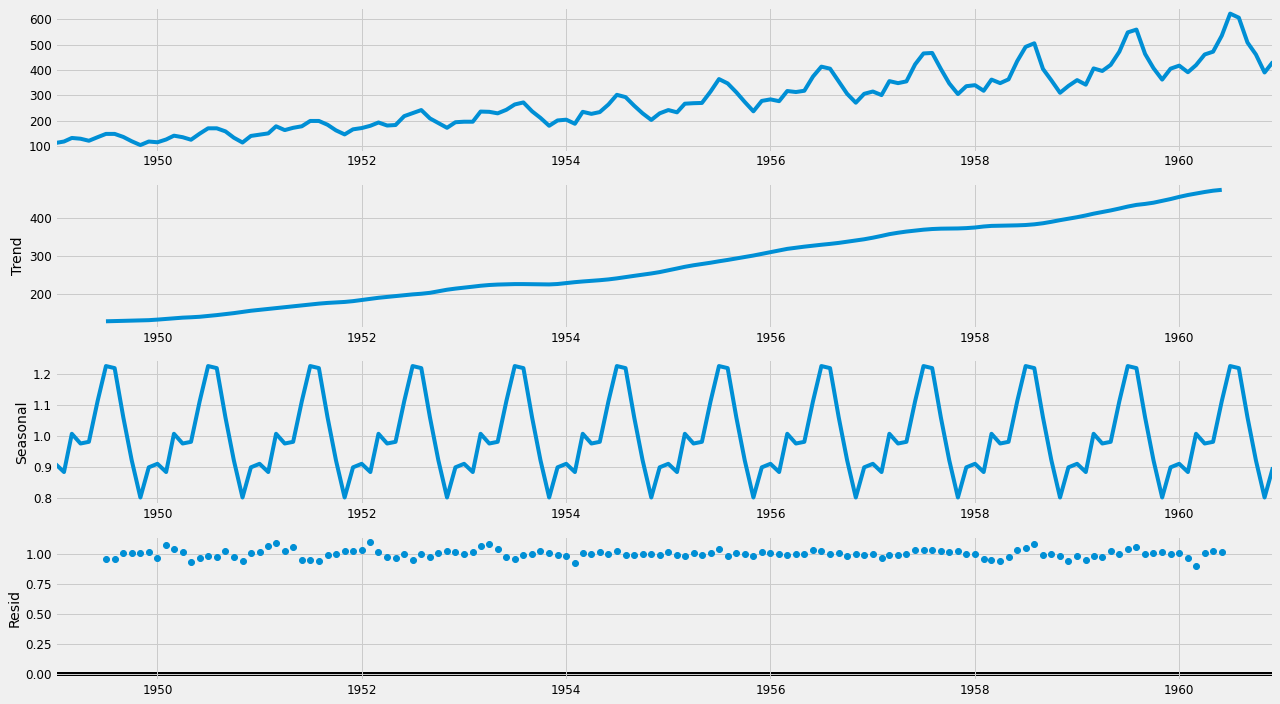

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Stationarity
<ul>
    <li>A Time Series is said to be stationary if its stastical properties sush as mean, variance remain constant over time.</li>
    <li>Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but one way for stationary.</li>
    <li>Intutively we can say that if a Time Series has a particular behavour over time there is a very high probablity that it will follow the same in the future
    <li>Also the theories related ti stationary series are more mature and easier to implement as compared to non-stationary series.</li>
<ul>    

<AxesSubplot:xlabel='year'>

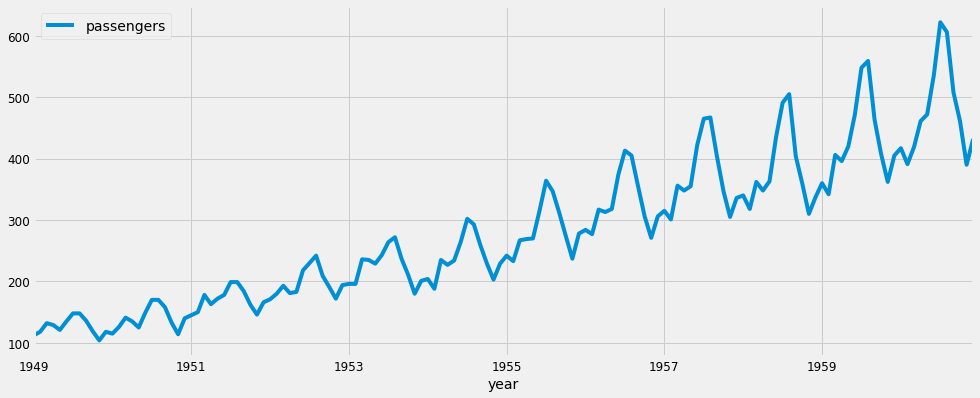

In [17]:
y.plot(figsize=(15, 6))

### We can check stationary using the followin:
<ul>
    <li><b>ACF and PACF plots</b>:If the TS is stationary, the ACF/PACF plots will show a <b>quick drop-off in correlation</b> after a small amount of lag between points</li>
    <li><b>Plotting Rolling Statistics:</b>We can plot the moving average or moving variance ans see if it varies with time. Moving average/variance is for any instant 't', the average/variance of the last year. i.e last 12 months</li>
    <li><b>Augmented Dickey-Fuller Test</b>: This is one of the stastical tests for checking stationary. here the null hypothesis is that the TS is non-stationary. The test results comprise of a test Statistics ans some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary. Refer the article for details</li>
</ul>

### ACF and PACF plots

<ul>
    <li>let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PCAF) plots</li>
    <li>If the time series is stationary, the ACF/PACF plots will show a <b>quick drop-off in correlation</b> after a small amount of lag between points</li>
    <li>This data is non-stationary as high number of previous observation are correlated with future values.</li>
    <li>Confidence intervals are drown as a cone</li>
    <li>By default, this is et to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statisical fluke.</li>
    <li>The partial autocorrelation atlag k is the correation that results after removing the effect of any correlation due to the terms at shorter lags</li>
</ul>

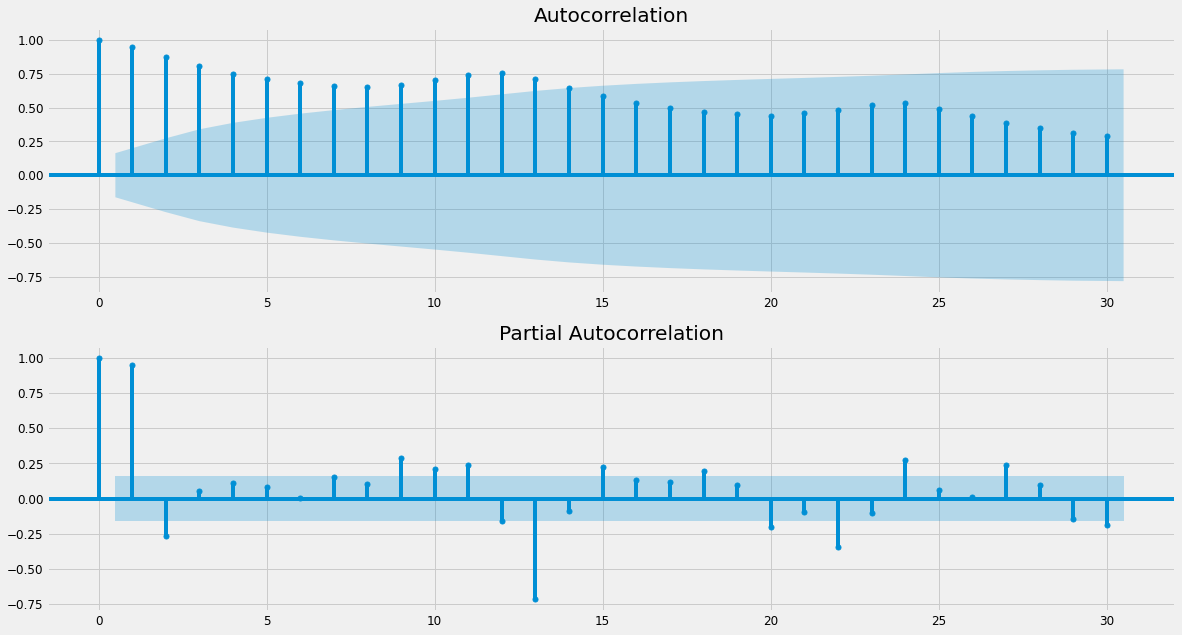

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics

<ul>
    <li>We observed that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)</li>
    <li>The time series is hence not stationary</li>
<ul>

In [19]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


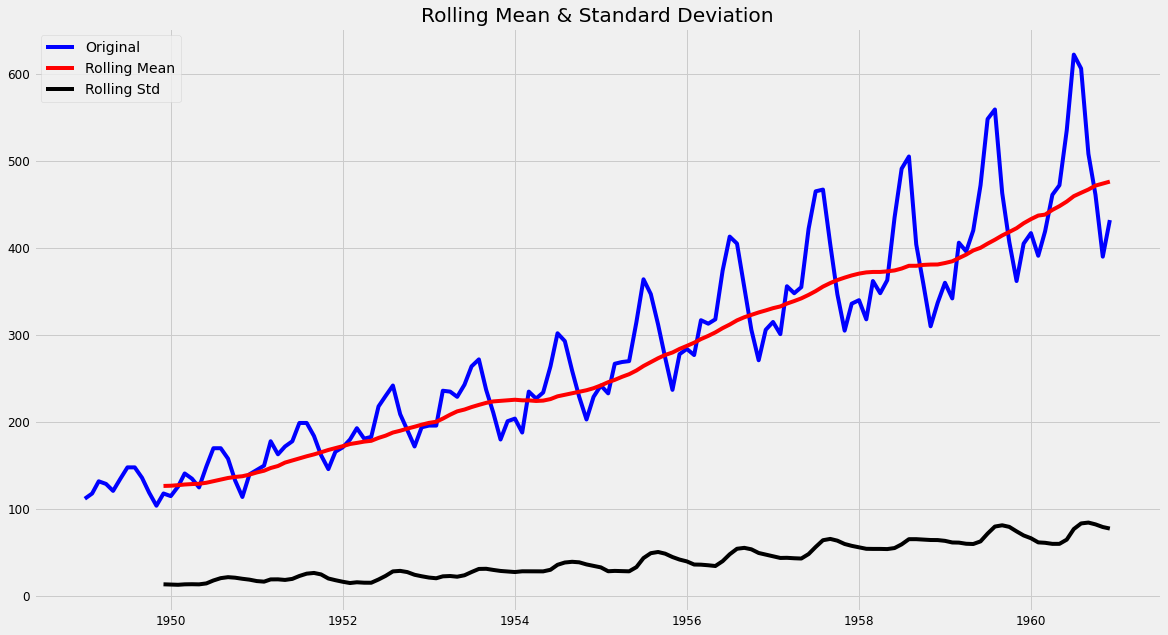

In [20]:
# Determining rolling statistics 
rolmean = y.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = y.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [21]:
# As you see the rolling Mean is not constant as it is increasing

### Augmented Dickey-Fuller Test

<ul>
    <li>The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predecting the change in y(t)</li>
    <li>Null hypothesis: the time series is not stationary</li>
    <li>Accept the null hypothesis (i.e a very low p-value) will indicate stationary</li>
</ul>

In [22]:
# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

Results of Dickey Fuller Test
Test Statistic             0.815369
p-value                    0.991880
#Lags Used                13.000000
Number of Observation    130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


## Making Time Series Stationary

<p>There are 2 major reasons behind non-stationary of a TS:</p>
<ol>
    <li><b>Trend</b> - varying mean over time For e.g in This case we saw that on average, the number of passenger was growing over time</li>
    <li><b>Seasonality</b> - variations at specific time-frame. eg people might have a tendency to buy cars in a particular month beacuse of pay increment or festivals</li>
</ol>

## Transformations
<ul>
    <li>We can apply transformation which prnalize higher values more than smaller values. These can be taking a log, square root, cube root, etc Lets take a log Transformation here for simplicity</li>
</ul>

### LogScale Transformation 

In [23]:
import numpy as np

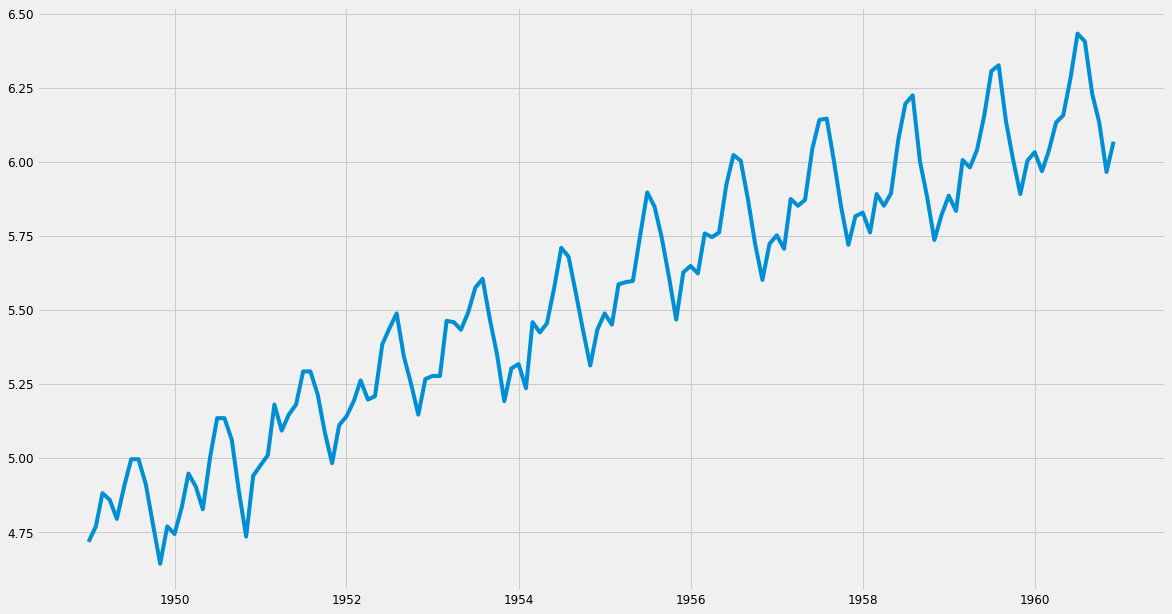

In [24]:
ts_log = np.log(y)
plt.plot(ts_log)

### Other possible transformation
<ul>
    <li>Exponential trnasform</li>
    <li>Box Cox transform</li>
    <li>Square root trnasformation</li>
</ul>

### Techniques to remove Trend - Smoothing
<ul>
    <li>Smoothing is taking rolling averages over windows of time</li>
</ul>    

### Movinf average
<ul>
    <li>we take average of 'k' consecutive values depending on the frequency of time sereis </li>
    <li>Here we can take the average over the past 1 year i.e last 12 (months)values</li>
    <li>A drawbackin this particular approach is that the time-period has to be strictly defined</li>
</ul>

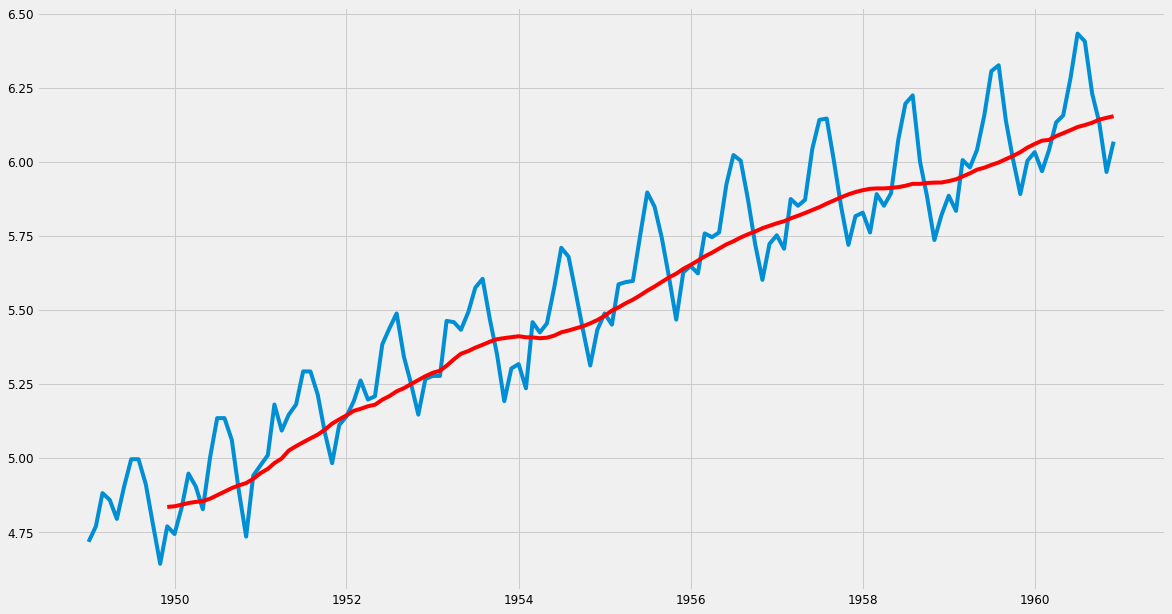

In [25]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

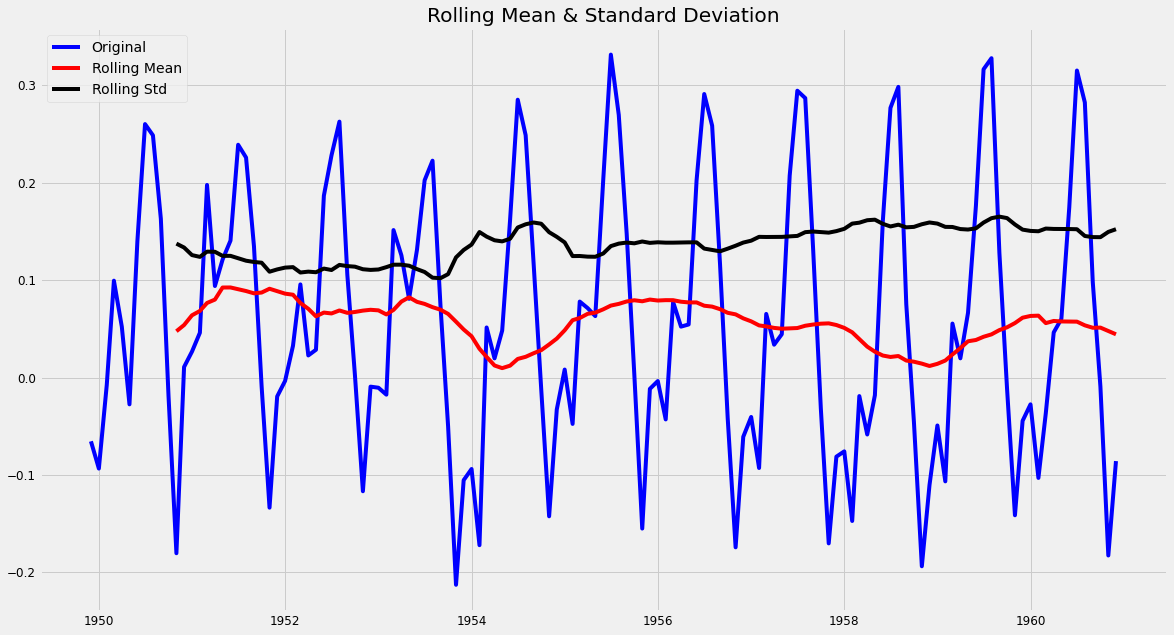

Results of Dickey Fuller Test
Test Statistic            -3.162908
p-value                    0.022235
#Lags Used                13.000000
Number of Observation    119.000000
Critical Value (1%)       -3.486535
Critical Value (5%)       -2.886151
Critical Value (10%)      -2.579896
dtype: float64


In [27]:
ts_log_moving_avg_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_moving_avg_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_moving_avg_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_moving_avg_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

In [28]:
ts_log_moving_avg_diff.head()

year
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: passengers, dtype: float64

### Exponentially weighted moving average: (exponential smoothining)
<ul>
    <li>To over come the problem of choosing a defined window in the moving average, we can use exponential weighted moving average</li>
    <li>We take a 'weighted moving average' where more recent values are given a higher weight.</li>
    <li>There can be many technique for assigning weights. Apopular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor</li>
</ul>    

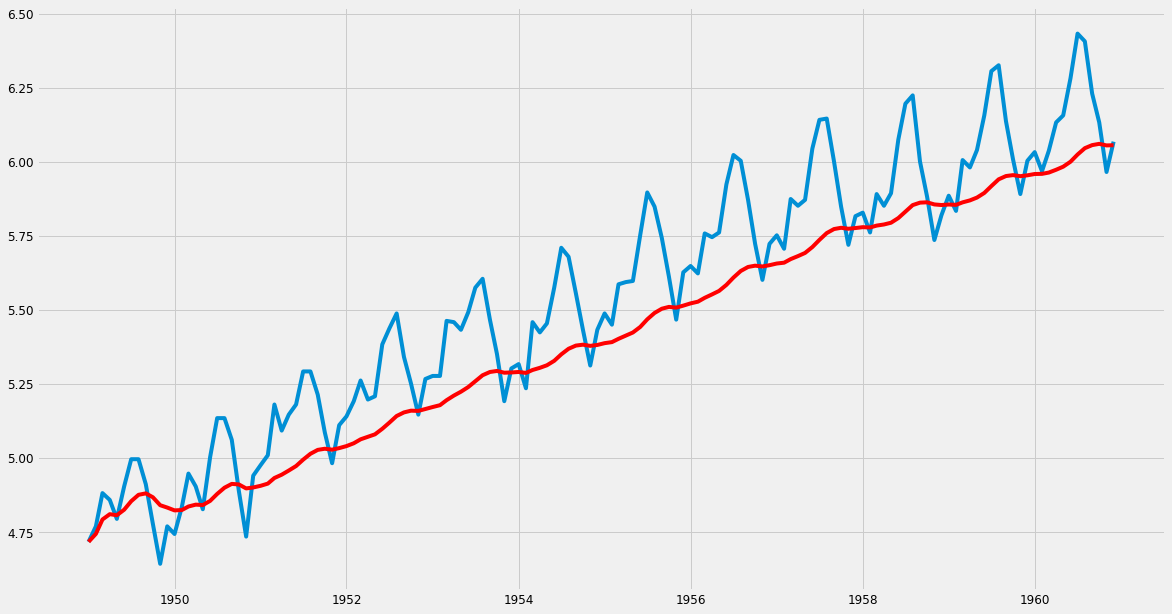

In [29]:
expwighted_avg =  ts_log.ewm(halflife=12).mean()
# pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

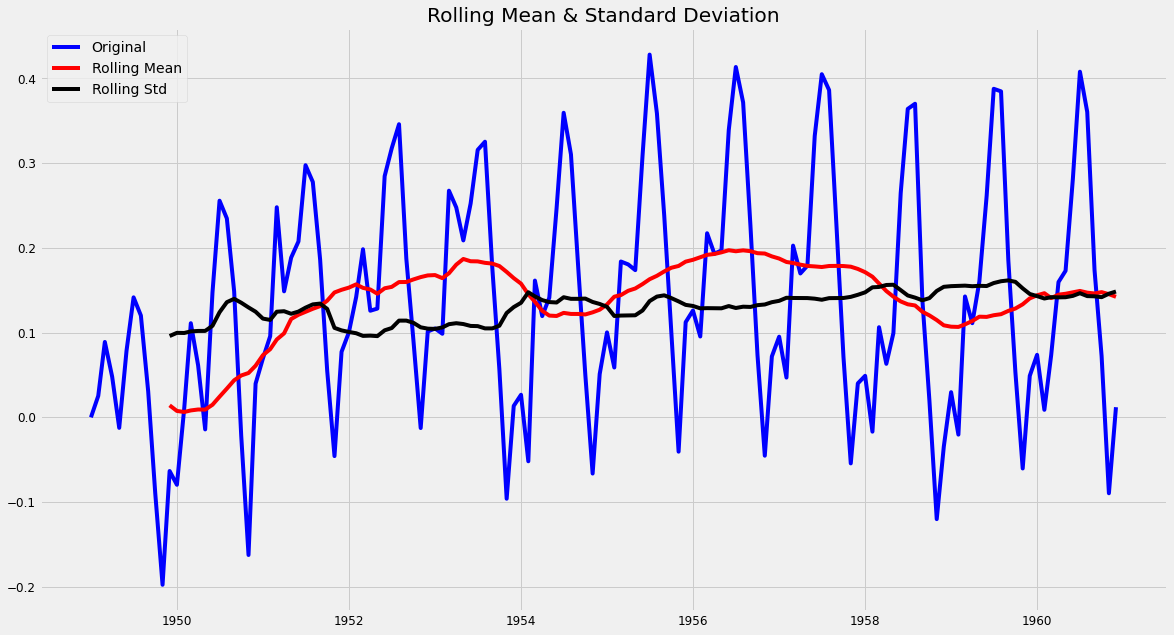

Results of Dickey Fuller Test
Test Statistic            -3.601262
p-value                    0.005737
#Lags Used                13.000000
Number of Observation    130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


In [30]:
ts_log_ewma_diff = ts_log - expwighted_avg

ts_log_ewma_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_ewma_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_ewma_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_ewma_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_ewma_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)    

### Future Techniques to remove Seasonality and Trend
<ul>
    <li>The simple trend reduction techniques discussed before dont work in all cases, particularly the ones with high seasonality</li>
<!--     <li></li> -->
</ul>

### Differencing
<ul>
    <li>In this technique, we take the difference of the observation at a particular instant with that at the previous instant</li>
    <li>First oreder differencing in Pandas</li>
</ul>

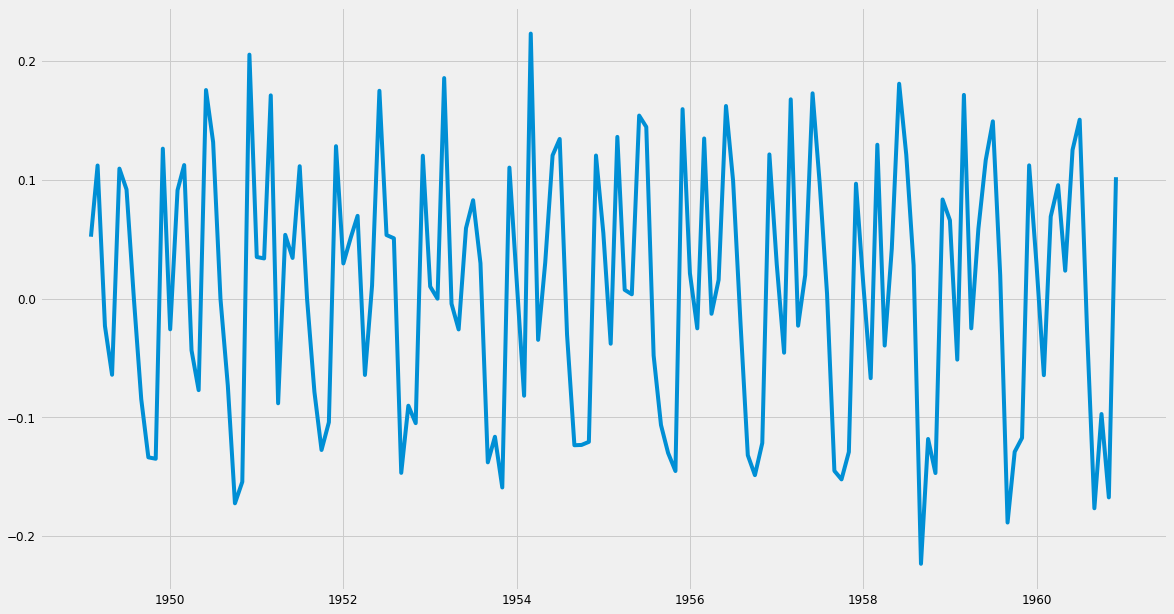

In [31]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

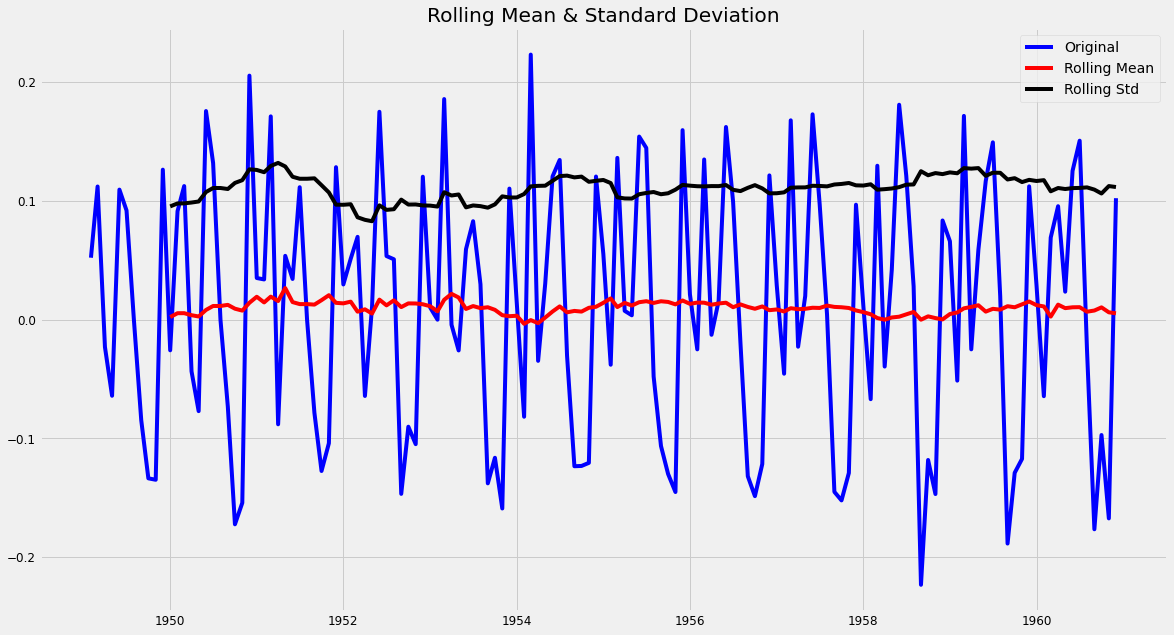

Results of Dickey Fuller Test
Test Statistic            -2.717131
p-value                    0.071121
#Lags Used                14.000000
Number of Observation    128.000000
Critical Value (1%)       -3.482501
Critical Value (5%)       -2.884398
Critical Value (10%)      -2.578960
dtype: float64


In [32]:
ts_log_diff.dropna(inplace=True)
# Determining rolling statistics 
rolmean = ts_log_diff.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_diff.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)   

### Decomposition 
<ul>
    <li>IN this approach, both trend and seasonality are modeled seoerately and the remaining part of the series is returned</li>
</ul>

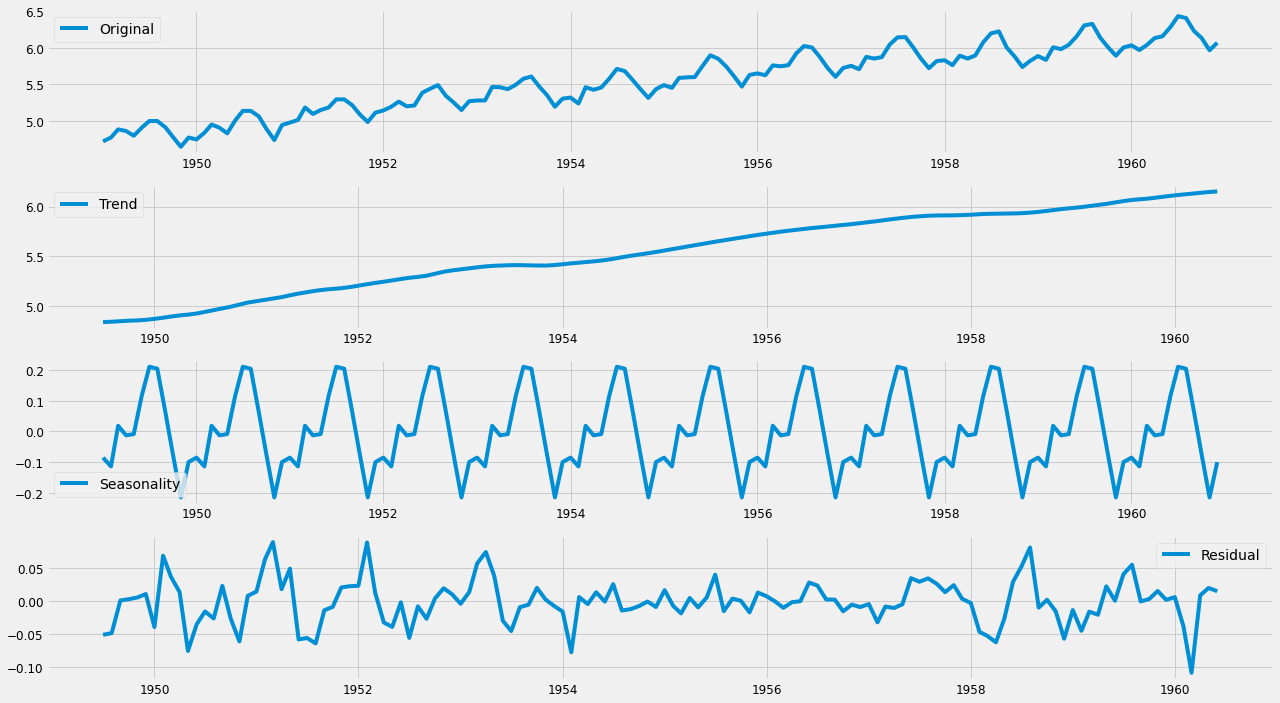

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
## it is to show even after the transformation actual data is preserved

In [35]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

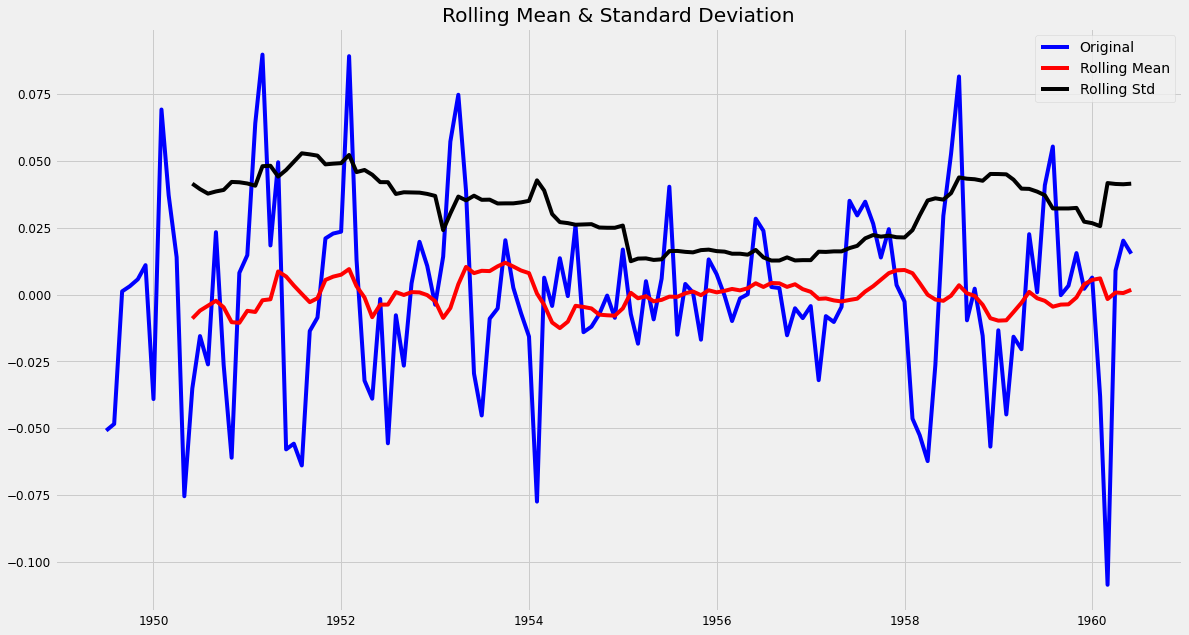

Results of Dickey Fuller Test
Test Statistic          -6.332387e+00
p-value                  2.885059e-08
#Lags Used               9.000000e+00
Number of Observation    1.220000e+02
Critical Value (1%)     -3.485122e+00
Critical Value (5%)     -2.885538e+00
Critical Value (10%)    -2.579569e+00
dtype: float64


In [36]:
rolmean = ts_log_decompose.rolling(window=12).mean()
# pd.rolling_mean(y, window=12)
rolstd = ts_log_decompose.rolling(window=12).std() 
# pd.rolling_std(y, window=12)


#Plot rolling statistics
orig = plt.plot(ts_log_decompose, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Perform Dickey Fuller Test
print('Results of Dickey Fuller Test')
dftest = adfuller(ts_log_decompose, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s) '%key] =value
print(dfoutput)  

## Time Series forcasting

### Autoregression (AR)

<ul>
    <li>The autoregression (AR) method the next step in the sequence as a linear function of the observations at prior timesteps</li>
    <li><b>Number of AR (Auto-Regressive) terms (p)</b>:p is the parameter associated with auto-regressive aspect of the model which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)...x(t-5).</li>
</ul>

In [37]:
from statsmodels.tsa.ar_model import AR
from random import random

In [38]:
model = AR(ts_log_diff) # series has to be stationary as a result 
model_fit = model.fit()

c:\users\melwin\.conda\envs\tutorialdatascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


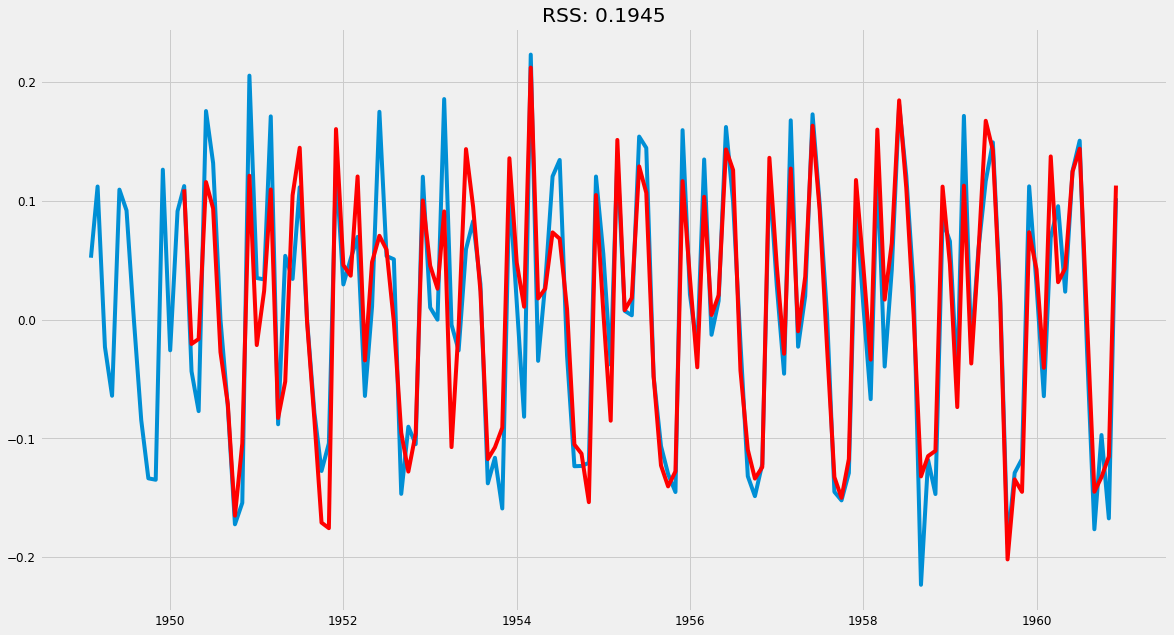

In [40]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()
# red coloured is the predected one 
# blue is the orginal one

In [ ]:
# to check the model is predected well we use RMSE 

### Reversing the Transformation 

#### Fitted or Predicted values

In [41]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


#### Cumulative Sum to reverse differencing

In [42]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


#### Adding 1st month value which was previously removed while differencing:

In [44]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

### Taking Exponent to reverse Log Transform:

In [46]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.514374')

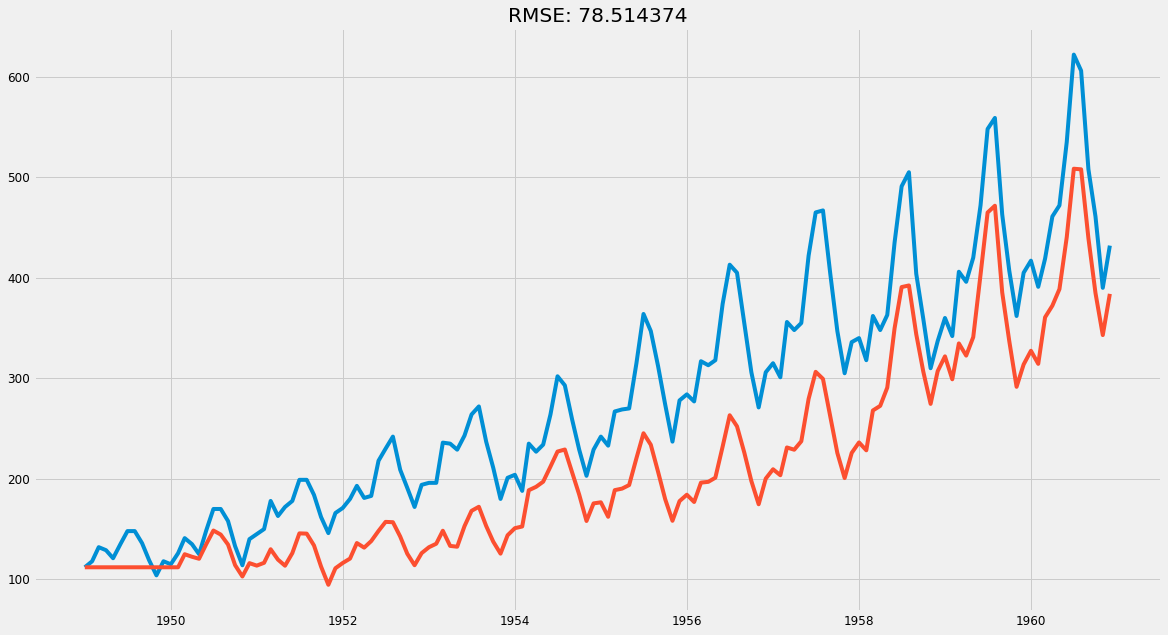

In [47]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %4f'%np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

In [ ]:
# as you see in the AR model predection is in right direction but there is lot of difference

### Forecast quality scoring metrics

<ul>
    <li>R squared</li>
    <li>Mean Absolute Error</li>
    <li>Mean Absolute Error</li>
    <li>Mean Squared Error</li>
    <li>Mean Squared Logrithmic Error</li>
    <li>Mean Absolute Percentage Error</li>
</ul>

In [61]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

<p><b>R squared</b>, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf,1]</p>
<ul>
<li>sklearn.metrics.r2_score</li>
</ul>

In [54]:
r2_score(y.passengers, predictions_ARIMA)

0.5686734896130738

<b>Mean Absolute Error</b> it is an interpretable metricbecause it has the same unit of measurement as the initial series [0,+inf)
<ul>
    <li>sklearn.metrics.mean_absolute_error</li>
</ul>    

In [56]:
mean_absolute_error(y.passengers, predictions_ARIMA)

69.42862838872753

<p><b>Mean Squared Error,</b> most commonly used, gives higher penalty to big mistakes and vise versa [0,+inf)</p>
<ul>
    <li>sklearn.metrics.mean_squared_error</li>
</ul>    

In [58]:
mean_squared_error(y.passengers, predictions_ARIMA)

6164.506983577638

<p><b>Mean Squared Logarithmic Error</b> pratically the same as MSE but initially take logarithm of the series as a result we give attention to spell mistake as well, usually is used when data has exponential trends [0,+inf)</p>
<ul>
    <li>sklearn.metrics.mean_squared_error</li>
</ul>

In [62]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.09945599448249762

<p><b>Mean Absolute Percentage Error</b>: same as MAE ... </p>

In [64]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.47240542986236

In [68]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def evaluate_forcast(y, pred):
    results                          = pd.DataFrame({'r2_score':r2_score(y, pred)},index=[0])
    results['mean_absolute_error']   = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse']                   = mean_squared_error(y, pred)
    results['msle']                  = mean_squared_log_error(y, pred)
    results['mape']                  = mean_absolute_percentage_error(y, pred)
    results['rmse']                  = np.sqrt(results['mse'])
    return results

In [69]:
evaluate_forcast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


In [ ]:
### Moving Average (MA)
<ul>
    <li></li>
</ul>

In [ ]:
what are decomposed pattern in time series 
what are trends, seasonality, Cyclic, and resedual
what is moving Average
what is exponential Smotheening 
what is 

In [ ]:
former step 
check weather the TS is stationary or not by(Rolling stats,mean, ACF, PACF, Fuller Test)
if its not stationary use Logtransformation (Normalization) to change it into stationary then do differencing
put the model AR,ARMA...
after generating the predection again we retransform (exponential function) it if any transformation is applied

In [ ]:
what is Log transformation of TS


what is differencing of TS
    taking the subraction of the current values from the previous value
    
what is the problem if i use the seasonality in the TS and predict in the Model ?
    Rsquare 